# Reading data and 1-D plotting with DISPATCH

**NB**: Remember to set the `PYTHONPATH` environment variable to `$DISPATCH_DIR/utilities/python`, where `$DISPATCH_DIR` is the location of your DISPATCH repository.

This notebook assumes you have already compiled DISPATCH for the 1-D MHD shock experiment (`make`) and run the code (`./dispatch.x`) successfully.
The data can be found in the `data` directory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dispatch
import dispatch.select
import itertools

First, read a snapshot.

In [2]:
datadir = '../../../experiments/mhd_shock/data'
snap = dispatch.snapshot(iout=9,verbose=1,data=datadir)

parsing ../../../experiments/mhd_shock/data/00009/snapshot.nml
  parsing io_nml
    adding property io
  parsing snapshot_nml
  parsing idx_nml
    adding property idx
  parsing units_nml
    adding property units
  parsing cartesian_params
    adding property cartesian
parsing ../../../experiments/mhd_shock/data/00009/rank_00000_patches.nml
  added 3 patches

timer:
snapshot metadata:   0.008 sec
         _patches:   0.003 sec


In [3]:
for p in snap.patches: print(p.id, p.position, p.size, p.time, p.gn, p.ds, p.level)

1 [0.16666667 0.005      0.005     ] [0.33333333 0.01       0.01      ] 0.09 [66  1  1] [0.00564972 0.01       0.01      ] 7
2 [0.5   0.005 0.005] [0.33333333 0.01       0.01      ] 0.09 [66  1  1] [0.00564972 0.01       0.01      ] 7
3 [0.83333333 0.005      0.005     ] [0.33333333 0.01       0.01      ] 0.09 [66  1  1] [0.00564972 0.01       0.01      ] 7


Printed from left to right are the patch ID, the centre of the patch in Cartesian coordinates, the time of the patch in the current snapshot, and the dimensions of the density/patch.

In this case, although we are dealing with a 1-D MHD shock tube, the solver employed does not permit true 1-D or 2-D calculations and thus there are a few dummy zones in the y- and z-directions.

In [4]:
indices = snap.patches[0].idx.vars.copy()
print(indices)
print("Patch kind:",snap.patches[0].kind)

{0: 'd', 4: 'e', 1: 'px', 2: 'py', 3: 'pz', 5: 'bx', 6: 'by', 7: 'bz'}
Patch kind: stagger2_mhd_pat


Note: From here on, we assume that the shock tube runs along the *x-direction*.

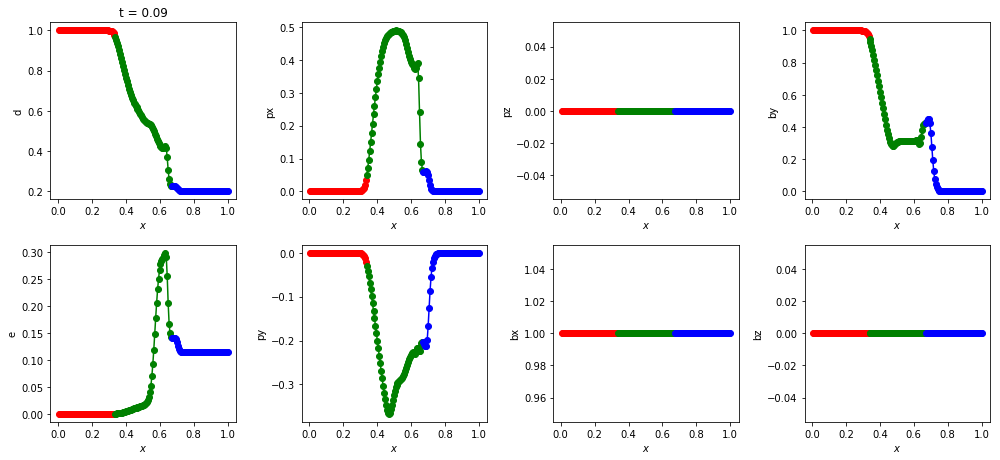

In [5]:
fig = plt.figure(figsize=(14.0,6.5))
fig.clf()
ncols, nrows = 4, 2
gs = fig.add_gridspec(ncols=ncols,nrows=nrows)
axes = []
for j,i in itertools.product(range(ncols),range(nrows)):
    cax = fig.add_subplot(gs[i,j])
    axes.append(cax)

if 'et' in indices.values(): indices.pop(snap.patches[0].idx.et) # If stored, don't plot total energy.

for cax, v in zip(axes, indices):
    colrs = itertools.cycle(['r','g','b','c','m','y','k'])    
    for p in snap.patches:
        jslice, kslice = 0, 0
        if p.kind == 'ramses_mhd_patch': jslice, kslice = 4,4
        cax.plot(p.x[p.li[0]:p.ui[0]],p.var(v)[p.li[0]:p.ui[0],jslice,kslice],marker='o',color=next(colrs),zorder=0.1*p.level)
    cax.set_xlabel(r'$x$')
    cax.set_ylabel(p.idx.vars[v])

axes[0].set_title(r't = {0:.03g}'.format(snap.patches[0].time))
fig.tight_layout()
plt.savefig(snap.patches[0].kind.strip())
plt.show()

Here are the MHD variables stored in this patch and their associated index in the data. `px` is the x-component of momentum, etc.
You don't have to remember these indices because you can always retrieve them using aliases, e.g., `patch.idx.d`.

Here's the density at t = 0.09. Different colours have been used for each patch.

Now what if you want to see all of the data as one single array (which can be useful for analysis)?

In [6]:
x, rho = dispatch.select.values_along(snap.patches,[0.0,0.0,0.0],dir=0,iv=snap.patches[0].idx.d)

Text(0, 0.5, '$\\rho$')

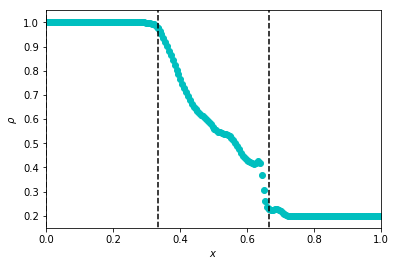

In [7]:
fig2 = plt.figure()
fig2.clf()
plt.plot(x,rho,'co')
for p in snap.patches:
    edge = p.position[0] - 0.5*p.size[0]
    plt.plot([edge,edge],[-10,10],'k--')
plt.axis(ymin=0.15,ymax=1.05,xmin=0.0,xmax=1.0)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')

Note that I've manually added vertical lines to denote patch boundaries.

In [8]:
print(rho.shape)

(180,)


As you can see, the data is now available as a single numpy array.